In [26]:
import numpy as np

import torch
import torch.nn as nn


import matplotlib.pyplot as plt

Model-Agnostic Meta-Learning (MAML) for Few-Shot Supervised Learning

As described in:
https://arxiv.org/abs/1703.03400

In [27]:
def maml(model_in, n_meta_iter, meta_batchsize, task_tau, batchsize, maml_stepsize = 0.1):
    for _ in range(n_meta_iter):
        trained_params = [] 
        
        
        task_list = [task_tau() for _ in range(meta_batchsize)]
            
        for task in task_list:
            trained_params.append(mlp_task_train(copy_model(model_in), task, batchsize = 10, lr = 0.02))

        initial_model = copy_model(model_in)

        with torch.no_grad():
            for trained_iter in range(len(trained_params)):
                for m_param, i_param, t_param in zip(model_in.parameters(),initial_model.parameters(), trained_params[trained_iter].parameters()):
                    m_param -= maml_stepsize * (i_param - t_param)

Reptile Algorithim:

As Described in:
https://arxiv.org/abs/1803.02999

In [28]:
def reptile_serial(model_in, n_meta_iter, task_tau, batchsize = 10, reptile_stepsize = 0.1):
    for _ in range(n_meta_iter):
        trained_mlp = mlp_task_train(copy_model(model_in), task_tau, batchsize= batchsize, lr = 0.02)
        with torch.no_grad():
            for phi, phi_tau in zip(model.parameters(), trained_mlp.parameters()):
                phi.data = phi.data + (reptile_stepsize * (phi_tau.data - phi.data))

Case Study: One-Dimensional Sine Wave Regression

In [29]:
class mlp(nn.Module):
    def __init__(self, input_dim=1, hl1_dim=64, hl2_dim = 64, output_dim=1):
        super(mlp, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hl1_dim), 
            nn.Tanh(),
            nn.Linear(hl1_dim, hl2_dim), 
            nn.Tanh(),
            nn.Linear(hl2_dim, output_dim),
            )

    def forward(self, x):
        return self.layers(x)

In [30]:
def task_a(a_min = 0.1, a_max = 5.0):
    a = np.random.rand()
    a = a * (a_max - a_min) + a_min
    
    phase = 2 * np.pi * np.random.rand()
    
    #Using torch linspace and sin so that it makes tensors
    x_tau = torch.linspace(-5, 5, 50)
    y_tau = a * torch.sin(x_tau + phase)

    return x_tau, y_tau

In [31]:
def mlp_task_train(model_in, task_func, batchsize = 10, lr = 0.02):

    loss_calc = nn.MSELoss()


    optim = torch.optim.SGD(model_in.parameters(), lr=lr)
    #Can use SGD or Adam optimiser, using SGD currently
    #optim = torch.optim.Adam(model_in.parameters(), lr=lr)


    x_tau, y_tau = task_a()

    for batch_iter in range(x_tau.shape[0] // batchsize):
        index_train_slice = torch.randperm(x_tau.shape[0])[batch_iter*batchsize:(batch_iter*batchsize)+batchsize]

        batch_in = x_tau[index_train_slice].reshape(-1,1)
        batch_target = y_tau[index_train_slice].reshape(-1,1)

        train_step(model_in, batch_in, batch_target, optim)
        
    return model_in

In [32]:
def train_step(model_in, x_tau, y_tau, optim_in):
    loss_calc = nn.MSELoss()

    loss = loss_calc(model_in(x_tau), y_tau)
    optim_in.zero_grad()
    loss.backward()
    optim_in.step()    


In [37]:
def eval_model_plot(model, x_eval, y_eval, plt_title = "", num_eval = 32, lr = 0.02):
    optim = torch.optim.SGD(model.parameters(), lr=lr)

    index_train_slice = torch.randperm(x_eval.shape[0])[0:10]
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    x_eval_slice = x_eval[index_train_slice]
    y_eval_slice = y_eval[index_train_slice]

    plt.plot(x_eval, y_eval, label='True Function', linewidth=2, color='black')
    
    for train_iter in range(num_eval):
        model_output = model(x_eval)
        if train_iter % 8 == 0:
            plt.plot(x_eval, model_output.data, label=f'After {train_iter} iter')
        train_step(model, x_eval_slice, y_eval_slice, optim)

    model_output = model(x_eval)
    plt.plot(x_eval, model_output.data, label=f'After {num_eval} iter')

    plt.title(plt_title)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


In [38]:
def copy_model(model):
    copy = type(model)()
    copy.load_state_dict(model.state_dict())
    return copy

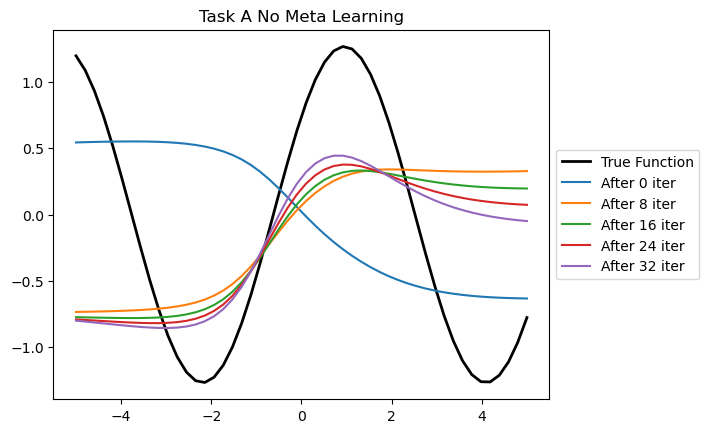

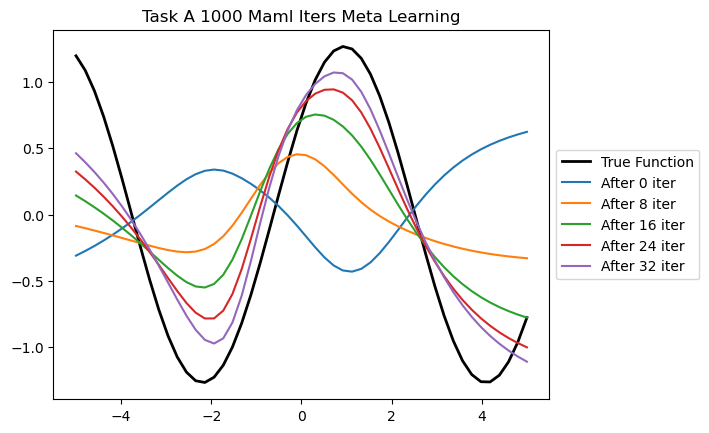

In [39]:
model = mlp()
x_eval, y_eval = task_a()
eval_model_plot(model, x_eval, y_eval, plt_title = "Task A No Meta Learning", num_eval = 32)

maml(model, 100, 10, task_a, 10, maml_stepsize = 0.1)

eval_model_plot(model, x_eval, y_eval, plt_title = "Task A 1000 Maml Iters Meta Learning", num_eval = 32)


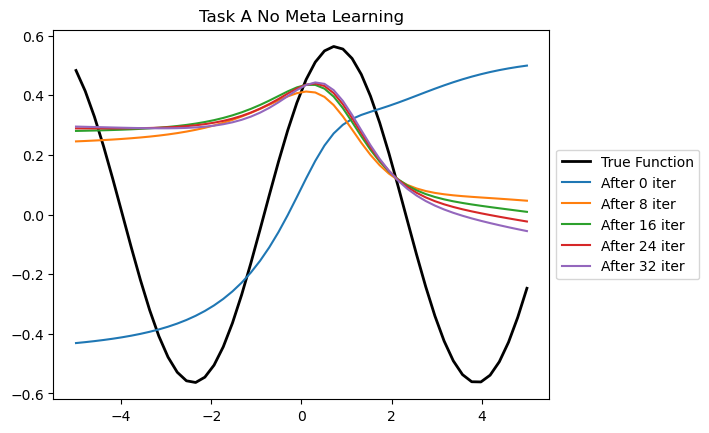

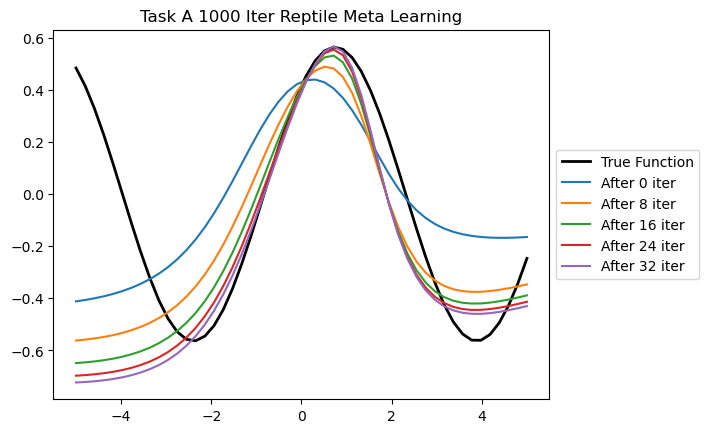

In [40]:
model = mlp()
x_eval, y_eval = task_a()


eval_model_plot(model, x_eval, y_eval, plt_title = "Task A No Meta Learning", num_eval = 32)

reptile_serial(model, 1000, task_a, batchsize = 10, reptile_stepsize = 0.1)


eval_model_plot(model, x_eval, y_eval, plt_title = "Task A 1000 Iter Reptile Meta Learning", num_eval = 32)



In [ ]:
#Code which runs both of these on the same problem, increasing it iters and shows how it progresses


In [ ]:
#code which plots the loss at each many trained iterations on group of tasks 
#and shows how those losses change w/ more meta iterations on both maml and reptile

In [ ]:
#Otherwise add more general writeup, bring in the equations and screenshots from the papers

In [41]:
#generate 10 eval problems



In [87]:



def loss_measures(model, x_eval_list, y_eval_list, lr = 0.02):
    eval_performance_set = []

    loss_calc = nn.MSELoss()

    for i in range(len(x_eval_list)):
        x_eval = x_eval_list[i]
        y_eval = y_eval_list[i]
        
        eval_perf = []
        
        optim = torch.optim.SGD(model.parameters(), lr=lr)

        index_train_slice = torch.randperm(x_eval.shape[0])[0:10]
        x_eval = x_eval.reshape(-1,1)
        y_eval = y_eval.reshape(-1,1)
        x_eval_slice = x_eval[index_train_slice]
        y_eval_slice = y_eval[index_train_slice]
        for train_iter in range(32):
            model_output = model(x_eval)
            #calculate the loss of model output
            loss = loss_calc(model_output, y_eval)
            eval_perf.append(loss.item())
            
            train_step(model, x_eval_slice, y_eval_slice, optim)
        eval_performance_set.append(eval_perf)
    
    return eval_performance_set


In [129]:
from tqdm import tqdm

In [139]:
model = mlp()

x_eval_list = []
y_eval_list = []

loss_eval_list = []

for _ in range(100):
    x_eval, y_eval = task_a()
    x_eval_list.append(x_eval)
    y_eval_list.append(y_eval)
    
output = loss_measures(model, x_eval_list, y_eval_list, lr = 0.02)

loss_eval_list.append(output)

for _ in tqdm(range(10)):
    reptile_serial(model, 1000, task_a, batchsize = 10, reptile_stepsize = 0.1)

    output = loss_measures(model, x_eval_list, y_eval_list, lr = 0.02)

    loss_eval_list.append(output)

100%|██████████| 10/10 [01:50<00:00, 11.06s/it]


In [140]:
loss_eval_list_np = np.array(loss_eval_list)

In [141]:
loss_eval_list_np.shape

(11, 100, 32)

In [142]:
#a single layer of loss_eval_list contains the loss of each iteration of the model on each task for a single meta iteration
# I want to get the mean of the loss of each iteration of the model on each task for a single meta iteration

mean_loss_eval_list = np.mean(loss_eval_list_np, axis = 1)

In [143]:
mean_loss_eval_list.shape

(11, 32)

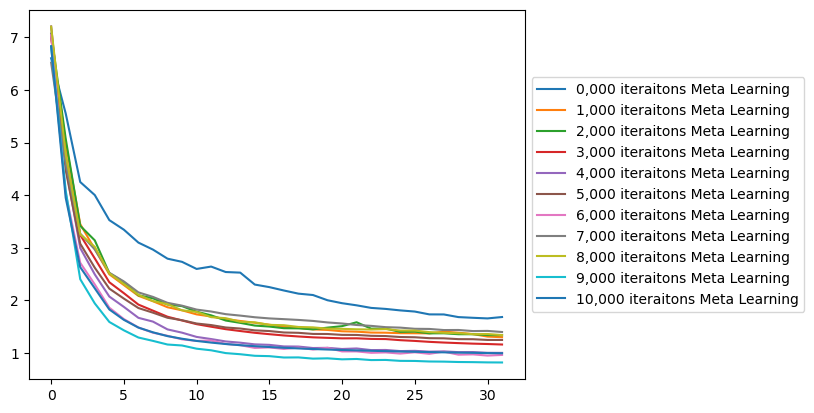

In [144]:
for i in range(mean_loss_eval_list.shape[0]):
    plt.plot(mean_loss_eval_list[i], label = f'{i},000 iteraitons Meta Learning')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


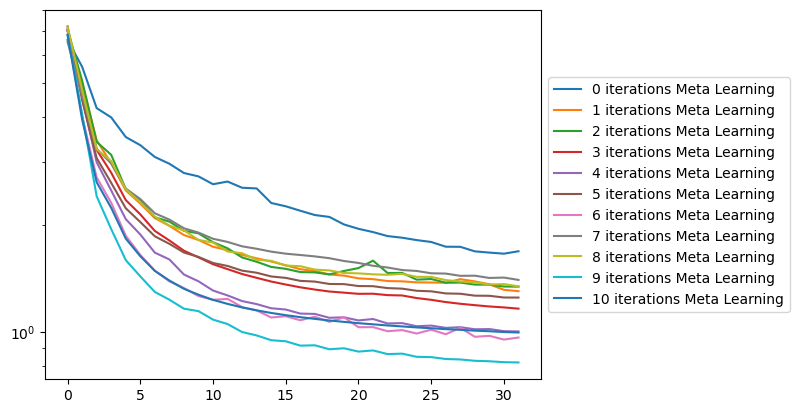

In [145]:
for i in range(mean_loss_eval_list.shape[0]):
    plt.plot(mean_loss_eval_list[i], label=f'{i},000 iterations Meta Learning')
    plt.yscale('log')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


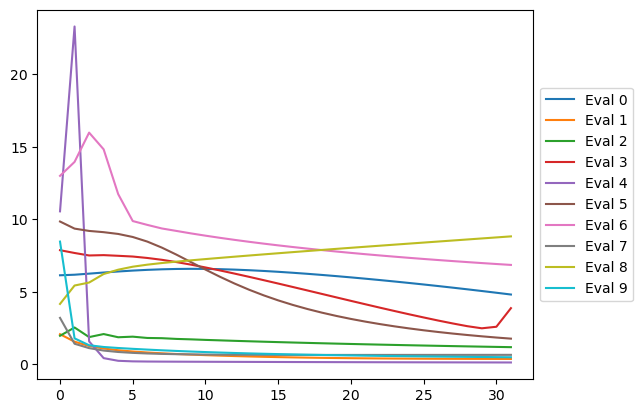

In [146]:
for i in range(eval_performance_set.shape[0]):
    plt.plot(eval_performance_set[i], label=f'Eval {i}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))